In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [21]:
columns = ['BRICKID', 'OBJID', 'TYPE', 'RA', 'DEC', 'EBV', 
          'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 
          'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 
          'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 
          'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 
          'GAIA_PHOT_G_MEAN_MAG', 'MASKBITS']

In [22]:
cat = Table(fitsio.read('/global/cscratch1/sd/landriau/dr9m-partial-sweep/south/sweep/sweep-160p015-170p020.fits', columns=columns))
print(len(cat))

3873703


In [23]:
cat['TYPE'] = cat['TYPE'].astype(str)

cat['FLUX_R_EC'] = cat['FLUX_R']/cat['MW_TRANSMISSION_R']
cat['FLUX_Z_EC'] = cat['FLUX_Z']/cat['MW_TRANSMISSION_Z']
cat['FLUX_W1_EC'] = cat['FLUX_W1']/cat['MW_TRANSMISSION_W1']

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Quality cuts
    mask = (cat['NOBS_G']>=2) & (cat['NOBS_R']>=2) & (cat['NOBS_Z']>=2)
    # GAIA duplicates (they all have empty photometry values):
    mask &= (cat['TYPE']!='DUP') & (cat['TYPE']!='DUP ')

    # # Quality in r: SNR_R > 0 && RFLUX > 0
    # mask &= (cat['FLUX_R']>0) & (cat['FLUX_IVAR_R']>0)

    # Quality in z: SNR_Z > 0 && ZFLUX > 0
    mask &= (cat['FLUX_Z']>0) & (cat['FLUX_IVAR_Z']>0)

    # Quality in W1: FLUX_IVAR_W1 > 0 && W1FLUX > 0
    mask &= (cat['FLUX_W1']>0) & (cat['FLUX_IVAR_W1']>0)

    # None-stellar color: (z-w1) > 0.8*(r-z) - 1.1 => -0.8*r + 1.8*z - W1 > -1.1
    mask_stellar = (cat['FLUX_R_EC']**(-0.8) * cat['FLUX_Z_EC']**1.8 / cat['FLUX_W1_EC'] < 10**(-0.4*(-1.1)))
    # Include non-point sources
    mask_stellar |= ((cat['TYPE']!='PSF') & (cat['TYPE']!='PSF '))

    mask &= mask_stellar

    mask &= (cat['FLUX_Z']>0) & (cat['FLUX_IVAR_Z']>0)
    mask &= (cat['FLUX_Z']/cat['MW_TRANSMISSION_Z'] > 10**(0.4*(22.5-22.0))) | (cat['FIBERFLUX_Z']/cat['MW_TRANSMISSION_Z'] > 10**(0.4*(22.5-22.5)))

In [25]:
cat = cat[mask]
print(len(cat))

965050


In [26]:
maskbits = [1, 5, 6, 7, 8, 9, 11, 12, 13]

mask_clean = np.ones(len(cat), dtype=bool)
for bit in maskbits:
    mask_clean &= (cat['MASKBITS'] & 2**bit)==0
print('{:} ({:.1f}%) objects removed by maskbits'.format(np.sum(~mask_clean), np.sum(~mask_clean)/len(mask_clean)*100))
cat = cat[mask_clean]
print(len(cat))

40139 (4.2%) objects removed by maskbits
924911


In [27]:
mask = (cat['FLUX_R']>0) & (cat['FLUX_IVAR_R']>0)
mask &= (cat['FLUX_Z']>0) & (cat['FLUX_IVAR_Z']>0)
mask &= (cat['FLUX_W1']>0) & (cat['FLUX_IVAR_W1']>0)
print(np.sum(~mask)/len(mask), np.sum(~mask))
cat = cat[mask]
print(len(cat))

0.0001254174726 116
924795


In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gmag = 22.5 - 2.5*np.log10(cat['FLUX_G']/cat['MW_TRANSMISSION_G'])
    rmag = 22.5 - 2.5*np.log10(cat['FLUX_R']/cat['MW_TRANSMISSION_R'])
    zmag = 22.5 - 2.5*np.log10(cat['FLUX_Z']/cat['MW_TRANSMISSION_Z'])
    w1mag = 22.5 - 2.5*np.log10(cat['FLUX_W1']/cat['MW_TRANSMISSION_W1'])
    w2mag = 22.5 - 2.5*np.log10(cat['FLUX_W2']/cat['MW_TRANSMISSION_W2'])
    rfibermag = 22.5 - 2.5*np.log10(cat['FIBERFLUX_R']/cat['MW_TRANSMISSION_R'])
    zfibermag = 22.5 - 2.5*np.log10(cat['FIBERFLUX_Z']/cat['MW_TRANSMISSION_Z'])

    gmag[~np.isfinite(gmag)] = 100.
    rmag[~np.isfinite(rmag)] = 100.
    zmag[~np.isfinite(zmag)] = 100.
    w1mag[~np.isfinite(w1mag)] = 100.
    w2mag[~np.isfinite(w2mag)] = 100.
    rfibermag[~np.isfinite(rfibermag)] = 100.
    zfibermag[~np.isfinite(zfibermag)] = 100.
    
    gflux_ivar = cat['FLUX_IVAR_R']

In [29]:
z2 = 16.83
print('{:.2f}  {:.2f}'.format(z2, z2/1.22))

lrg_mask = zmag - w1mag > 0.8 * (rmag-zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.5)                   # faint limit

mask_red = (gmag - w1mag > 2.6) & (gmag - rmag > 1.4) # low-z cut
mask_red |= (rmag-w1mag) > 1.8                   # ignore low-z cut for faint objects
lrg_mask &= mask_red

lrg_mask &= rmag - zmag > (zmag - z2) * 0.45       # sliding optical cut
lrg_mask &= rmag - zmag > (zmag - z2/1.22) * 0.19       # low-z sliding optical cut

print(np.sum(lrg_mask))
cat = cat[lrg_mask]

16.83  13.80
27012


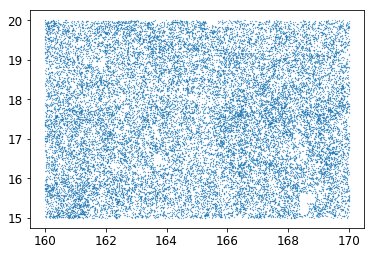

In [108]:
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.5)
plt.show()

In [30]:
cat

BRICKID,OBJID,TYPE,RA,DEC,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,NOBS_G,NOBS_R,NOBS_Z,NOBS_W1,NOBS_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,GAIA_PHOT_G_MEAN_MAG,MASKBITS,FLUX_R_EC,FLUX_Z_EC,FLUX_W1_EC
int32,int32,str3,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32
441305,166,DEV,163.862312927,19.4748149922,0.0345578,1.23351,4.12113,16.0199,52.5569,27.671,144.353,44.6083,8.23518,1.35785,0.349027,0.90276,0.933411,0.962189,0.994161,0.99641,3,3,3,199,176,0.239481,0.800101,3.11019,0.239501,0.800152,3.11031,0.0,0,4.41513,16.6494,52.8656
441305,280,REX,163.869414125,19.3804195016,0.0324087,0.191393,0.988749,5.26636,25.284,19.7834,1007.25,302.468,61.3987,2.77877,0.641572,0.908522,0.93742,0.964498,0.994523,0.996633,3,3,3,204,182,0.119427,0.616966,3.28613,0.120095,0.618636,3.28931,0.0,0,1.05476,5.46021,25.4233
441305,568,DEV,163.884881889,19.4738636576,0.0345356,0.389302,1.73192,7.62391,30.7298,16.6943,522.601,147.397,27.91,2.33209,0.573797,0.90282,0.933452,0.962212,0.994164,0.996412,3,3,3,201,178,0.157055,0.698702,3.07569,0.157055,0.698702,3.07569,0.0,0,1.85539,7.92331,30.9102
441305,607,DEV,163.886742262,19.4771939621,0.0346776,0.247038,1.1848,5.9762,20.1142,9.6468,597.851,182.01,21.1921,2.68252,0.623553,0.90244,0.933188,0.96206,0.99414,0.996397,3,3,2,202,179,0.111288,0.533738,2.6922,0.111288,0.533738,2.6922,0.0,0,1.26963,6.21187,20.2328
441305,738,EXP,163.894603257,19.5975574526,0.0317331,0.12409,0.882427,4.94746,24.0468,15.7769,793.522,244.119,46.2596,2.53732,0.630332,0.910341,0.938683,0.965225,0.994637,0.996703,3,3,3,201,180,0.0642639,0.456994,2.5622,0.064264,0.456995,2.56222,0.0,0,0.940069,5.1257,24.1765
441305,757,DEV,163.895591189,19.6240577407,0.0307109,0.111804,1.63957,9.90437,43.6182,25.3467,287.371,89.2918,16.5614,1.90913,0.498104,0.913099,0.940599,0.966326,0.994809,0.996809,3,3,3,207,187,0.0327717,0.480588,2.90315,0.0327717,0.480588,2.90315,0.0,0,1.74312,10.2495,43.8458
441305,765,SER,163.896298686,19.5042066212,0.0351517,0.814853,3.35349,12.1594,33.903,25.3117,416.355,126.629,23.7939,2.42955,0.579762,0.901175,0.932306,0.961551,0.994061,0.996348,3,3,3,198,176,0.236101,0.971659,3.52314,0.23721,0.978894,3.54538,0.0,0,3.59698,12.6456,34.1056
441305,830,DEV,163.900227713,19.5030266003,0.0351652,0.371873,1.85388,8.11359,26.9504,14.0552,639.73,193.737,38.4284,2.5528,0.602945,0.901139,0.932281,0.961537,0.994058,0.996347,3,3,3,197,176,0.178339,0.889065,3.89104,0.178339,0.889065,3.89104,0.0,0,1.98854,8.43815,27.1115
441305,908,DEV,163.905652927,19.4971629925,0.0351106,0.820359,3.66497,13.1397,33.7935,18.958,408.087,122.758,24.4071,2.22637,0.536521,0.901284,0.932383,0.961596,0.994067,0.996352,3,3,3,196,176,0.30652,1.36938,4.90954,0.30693,1.36973,4.9096,0.0,0,3.93076,13.6645,33.9952


In [31]:
len(np.unique(cat['BRICKID']))

817

In [61]:
tractor_dir = '/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south/tractor'
tractor_columns = ['brickid', 'objid', 'flux_z', 'nea_g', 'nea_r', 'nea_z', 'blob_nea_g', 'blob_nea_r', 'blob_nea_z']
columns_to_add = ['tractor_flux_z', 'nea_g', 'nea_r', 'nea_z', 'blob_nea_g', 'blob_nea_r', 'blob_nea_z']

bricks = Table.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-bricks.fits.gz')

In [62]:
for col in columns_to_add:
    cat[col] = -99.

In [63]:
brickid_list = np.unique(cat['BRICKID'])
print(len(brickid_list))
for ii, brickid in enumerate(brickid_list):
    
    if ii%100==0:
        print(ii, len(brickid_list))
    
    brick_mask = cat['BRICKID']==brickid
    brickname = bricks['BRICKNAME'][bricks['BRICKID']==brickid][0]
    tractor_path = os.path.join(tractor_dir, '{}/tractor-{}.fits'.format(brickname[:3], brickname))
    tractor = Table(fitsio.read(tractor_path, columns=tractor_columns))
    mask = np.in1d(tractor['objid'], cat['OBJID'][brick_mask])
    tractor = tractor[mask]

    t1_reverse_sort = np.array(cat['OBJID'][brick_mask]).argsort().argsort()
    tractor.sort('objid')
    tractor = tractor[t1_reverse_sort]
    tractor.rename_column('flux_z', 'tractor_flux_z')
    
    for col in columns_to_add:
        cat[col][brick_mask] = tractor[col]

817
0 817
1 817
2 817
3 817
4 817
5 817
6 817
7 817
8 817
9 817
10 817
11 817
12 817
13 817
14 817
15 817
16 817
17 817
18 817
19 817
20 817
21 817
22 817
23 817
24 817
25 817
26 817
27 817
28 817
29 817
30 817
31 817
32 817
33 817
34 817
35 817
36 817
37 817
38 817
39 817
40 817
41 817
42 817
43 817
44 817
45 817
46 817
47 817
48 817
49 817
50 817
51 817
52 817
53 817
54 817
55 817
56 817
57 817
58 817
59 817
60 817
61 817
62 817
63 817
64 817
65 817
66 817
67 817
68 817
69 817
70 817
71 817
72 817
73 817
74 817
75 817
76 817
77 817
78 817
79 817
80 817
81 817
82 817
83 817
84 817
85 817
86 817
87 817
88 817
89 817
90 817
91 817
92 817
93 817
94 817
95 817
96 817
97 817
98 817
99 817
100 817
101 817
102 817
103 817
104 817
105 817
106 817
107 817
108 817
109 817
110 817
111 817
112 817
113 817
114 817
115 817
116 817
117 817
118 817
119 817
120 817
121 817
122 817
123 817
124 817
125 817
126 817
127 817
128 817
129 817
130 817
131 817
132 817
133 817
134 817
135 817
136 817
137 817
13

In [66]:
np.all(cat['FLUX_Z']==cat['tractor_flux_z'])

True

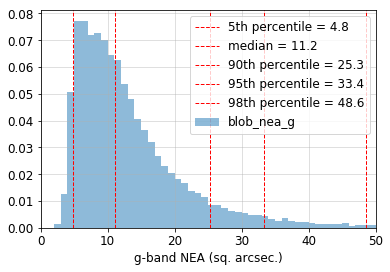

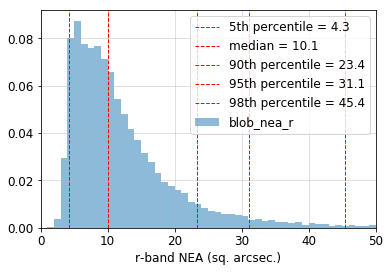

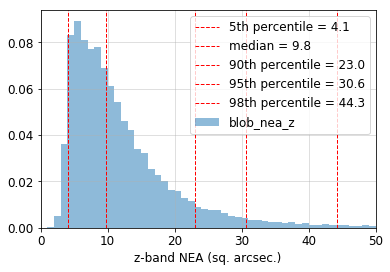

In [103]:
for col in ['nea_g', 'nea_r', 'nea_z']:
    # plt.hist(cat[col], 100, range=(0, 50), alpha=0.5, label=col)
    col1 = col.replace('nea', 'blob_nea')
    plt.hist(cat[col1], 50, range=(0, 50), alpha=0.5, label=col1, density=True)
    percentile = 5
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    v = np.median(cat[col1])
    plt.axvline(v, label='median = {:.1f}'.format(v), lw=1, color='r', ls='--')
    percentile = 90
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    percentile = 95
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    percentile = 98
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    plt.grid(alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('{}-band NEA (sq. arcsec.)'.format(col[-1]))
    plt.xlim(0, 50)
    plt.show()

In [85]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gmag = 22.5 - 2.5*np.log10(cat['FLUX_G']/cat['MW_TRANSMISSION_G'])
    rmag = 22.5 - 2.5*np.log10(cat['FLUX_R']/cat['MW_TRANSMISSION_R'])
    zmag = 22.5 - 2.5*np.log10(cat['FLUX_Z']/cat['MW_TRANSMISSION_Z'])
    w1mag = 22.5 - 2.5*np.log10(cat['FLUX_W1']/cat['MW_TRANSMISSION_W1'])
    w2mag = 22.5 - 2.5*np.log10(cat['FLUX_W2']/cat['MW_TRANSMISSION_W2'])
    rfibermag = 22.5 - 2.5*np.log10(cat['FIBERFLUX_R']/cat['MW_TRANSMISSION_R'])
    zfibermag = 22.5 - 2.5*np.log10(cat['FIBERFLUX_Z']/cat['MW_TRANSMISSION_Z'])

    gmag[~np.isfinite(gmag)] = 100.
    rmag[~np.isfinite(rmag)] = 100.
    zmag[~np.isfinite(zmag)] = 100.
    w1mag[~np.isfinite(w1mag)] = 100.
    w2mag[~np.isfinite(w2mag)] = 100.
    rfibermag[~np.isfinite(rfibermag)] = 100.
    zfibermag[~np.isfinite(zfibermag)] = 100.
    
    gflux_ivar = cat['FLUX_IVAR_R']

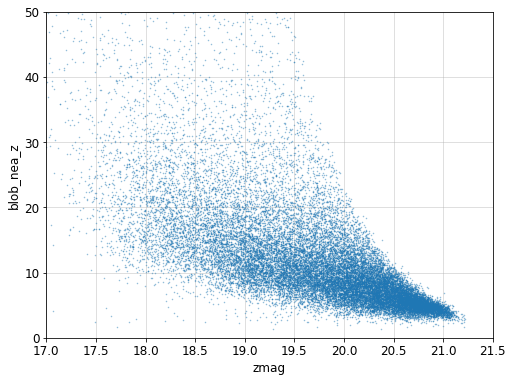

In [99]:
plt.figure(figsize=(8, 6))
plt.plot(zmag, cat['blob_nea_z'], '.', ms=1, alpha=0.5)
plt.axis([17, 21.5, 0, 50])
plt.grid(alpha=0.5)
plt.xlabel('zmag')
plt.ylabel('blob_nea_z')
plt.show()